# Compute DWPCs for all metapaths

Modified from https://github.com/greenelab/connectivity-search-analyses/blob/main/explore/bulk-pipeline/bulk.ipynb

In [2]:
import collections
import pathlib
import shutil
import zipfile

import numpy
import pandas
import tqdm

import hetmatpy.degree_weight
from hetmatpy.hetmat import HetMat
import hetmatpy.hetmat.caching
import hetmatpy.degree_group
import hetmatpy.pipeline
from hetmatpy.hetmat.archive import create_archive, create_archive_by_globs

import hetnetpy

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
url = 'https://github.com/dhimmel/hetionet/raw/76550e6c93fbe92124edc71725e8c7dd4ca8b1f5/hetnet/json/hetionet-v1.0.json.bz2'
graph = hetnetpy.readwrite.read_graph(url)

In [4]:
from hetmatpy.hetmat import hetmat_from_graph
import os

path = './hetionet-v1.0.hetmat'
os.makedirs(path, exist_ok=True)
hetmat = hetmat_from_graph(graph, path)

In [5]:

hetmatpy.degree_weight.default_dwwc_method = hetmatpy.degree_weight.dwwc_recursive

In [6]:
# set DWPC damping exponent
damping = 0.5

# if danger is True, delete existing path-counts, adjusted-path-counts, and archives
danger = True
clear_adjusted_pcs = True

In [7]:
# All metapaths up to length 3
metapaths = hetmat.metagraph.extract_all_metapaths(max_length=3, exclude_inverts=True)
len(metapaths)

2205

In [8]:
# # Overwrite metapaths for testing purposes
metapaths = [ 'SpDpS', 'GeAlD']
metapaths = list(map(hetmat.metagraph.get_metapath, metapaths))
metapaths

[SpDpS, GeAlD]

In [9]:
metapath_to_stats = dict()

In [10]:
if danger:
    for delete_dir in hetmat.directory.glob('path-counts/*'):
        shutil.rmtree(delete_dir)
if danger or clear_adjusted_pcs:
    for delete_dir in hetmat.directory.glob('adjusted-path-counts/*'):
        shutil.rmtree(delete_dir)

### Compute path counts

Note that we probably want to make this more intelligent to not read then write inverse of an existing on-disk metapath.

In [11]:
hetmat.path_counts_cache = hetmatpy.hetmat.caching.PathCountPriorityCache(hetmat, allocate_GB=16)
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, pc_matrix = hetmatpy.degree_weight.dwpc(hetmat, metapath, damping=0, dense_threshold=1, dtype='uint64')
    path = hetmat.get_path_counts_path(metapath, 'dwpc', 0, None)
    path.parent.mkdir(parents=True, exist_ok=True)
    if not path.exists():
        hetmatpy.hetmat.save_matrix(pc_matrix, path)
    metapath_to_stats[metapath] = collections.OrderedDict({
        'metapath': str(metapath),
        'length': len(metapath),
        'n_pairs': numpy.prod(pc_matrix.shape),
        'pc_density': pc_matrix.count_nonzero() / numpy.prod(pc_matrix.shape),
        'pc_mean': pc_matrix.mean(),
        'pc_max': pc_matrix.max(),
    })
    del pc_matrix

100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


In [12]:
print(hetmat.path_counts_cache.get_stats())
hetmat.path_counts_cache = None

PathCountPriorityCache containing 3 items
  total gets: 3
  cache hits: memory = 0, disk = 0, absent = 3
  0.02 GB in use of 16.00 GB allocated


### Compute DWPCs

In [13]:
hetmat.path_counts_cache = hetmatpy.hetmat.caching.PathCountPriorityCache(hetmat, allocate_GB=16)
for metapath in tqdm.tqdm(metapaths):
    row_ids, col_ids, dwpc_matrix = hetmatpy.degree_weight.dwpc(hetmat, metapath, damping=damping, dense_threshold=0.7, dtype='float64')
    path = hetmat.get_path_counts_path(metapath, 'dwpc', damping, None)
    if not path.exists():
        hetmatpy.hetmat.save_matrix(dwpc_matrix, path)
    stats = metapath_to_stats[metapath]
    stats[f'dwpc-{damping}_raw_mean'] = dwpc_matrix.mean()
    del dwpc_matrix

100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


In [14]:
print(hetmat.path_counts_cache.get_stats())
hetmat.path_counts_cache = None

PathCountPriorityCache containing 3 items
  total gets: 3
  cache hits: memory = 0, disk = 0, absent = 3
  0.02 GB in use of 16.00 GB allocated


In [15]:
metapath_df = pandas.DataFrame(list(metapath_to_stats.values()))
metapath_df.to_csv('metapath-dwpc-stats.tsv', sep='\t', index=False, float_format='%.6g')
metapath_df

,metapath,length,n_pairs,pc_density,pc_mean,pc_max,dwpc-0.5_raw_mean
0,SpDpS,2,191844,0.314391,0.671264,30,0.001777
1,GeAlD,2,2869465,0.622090,2.274355,37,0.000273


Top 10 DWPC scores: [0.06804138 0.06019293 0.05555556 0.0550459  0.05455447 0.05206821
 0.05184758 0.05040409 0.04884507 0.0476679 ]

Number of non-zero connections: 2869465
Mean DWPC: 0.000273
Median DWPC: 0.000163
Max DWPC: 0.068041


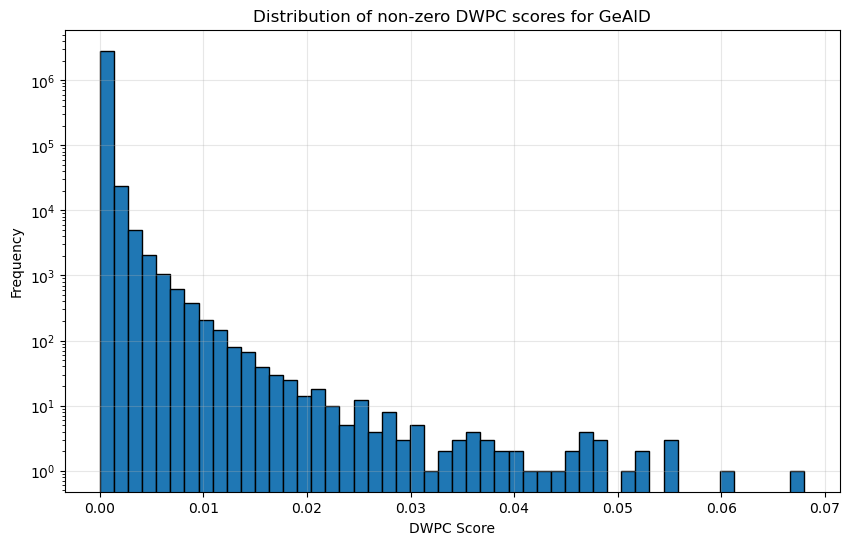

In [22]:
# Get DWPC matrix for GeAlD with damping=0.5
metapath = hetmat.metagraph.get_metapath('GeAlD')
row_ids, col_ids, dwpc_matrix = hetmatpy.degree_weight.dwpc(hetmat, metapath, damping=0.5, dense_threshold=0.7, dtype='float64')

# Convert to array for easier analysis 
dwpc_values = dwpc_matrix.toarray().flatten()
# Sort dwpc_values in descending order
top_dwpc_values = numpy.sort(dwpc_values)[::-1]
print("Top 10 DWPC scores:", top_dwpc_values[:10])

# Only look at non-zero values
# dwpc_values = dwpc_values[dwpc_values > 0]

print(f"\nNumber of non-zero connections: {len(dwpc_values)}")
print(f"Mean DWPC: {dwpc_values.mean():.6f}")
print(f"Median DWPC: {numpy.median(dwpc_values):.6f}")
print(f"Max DWPC: {dwpc_values.max():.6f}")

# Plot histogram of DWPC distribution
plt.figure(figsize=(10, 6))
plt.hist(dwpc_values, bins=50, edgecolor='black')
plt.title('Distribution of non-zero DWPC scores for GeAlD')
plt.xlabel('DWPC Score')
plt.ylabel('Frequency')
plt.yscale('log')  # Use log scale for y-axis to better visualize distribution
plt.grid(True, alpha=0.3)
plt.show()



### Generate running DGP metrics

In [13]:
# Attempt to diagnose memory leak in https://github.com/greenelab/hetmech/issues/141
import tracemalloc
tracemalloc.start()
snapshots = [tracemalloc.take_snapshot()]

In [14]:
for name, permat in tqdm.tqdm(hetmat.permutations.items()):
    permat.path_counts_cache = hetmech.hetmat.caching.PathCountPriorityCache(permat, allocate_GB=16)
    for metapath in metapaths:
        dwpc_mean = metapath_to_stats[metapath][f'dwpc-{damping}_raw_mean']
        degree_grouped_df = hetmech.degree_group.single_permutation_degree_group(
            permat, metapath, dwpc_mean=dwpc_mean, damping=damping)
        path = hetmat.get_running_degree_group_path(metapath, 'dwpc', damping, extension='.pkl')
        path.parent.mkdir(parents=True, exist_ok=True)
        if path.exists():
            running_df = pandas.read_pickle(path)
            running_df += degree_grouped_df
        else:
            running_df = degree_grouped_df
        running_df.to_pickle(path)
    permat.clear_caches()
    snapshots.append(tracemalloc.take_snapshot())

100%|██████████| 200/200 [360:43:33<00:00, 6493.07s/it]    


In [15]:
# https://docs.python.org/3/library/tracemalloc.html
malloc_stats = snapshots[-1].compare_to(snapshots[0], 'lineno')
for malloc_stat in malloc_stats[:6]:
    print(malloc_stat)

/home/dhimmel/anaconda3/envs/hetmech/lib/python3.6/pathlib.py:69: size=5133 KiB (+5133 KiB), count=201 (+201), average=25.5 KiB
/home/dhimmel/anaconda3/envs/hetmech/lib/python3.6/site-packages/pandas/io/pickle.py:166: size=153 KiB (+153 KiB), count=361 (+361), average=435 B
/home/dhimmel/anaconda3/envs/hetmech/lib/python3.6/pathlib.py:666: size=109 KiB (+109 KiB), count=1001 (+1001), average=112 B
/home/dhimmel/Documents/greene/hetmech/hetmech/degree_group.py:58: size=99.5 KiB (+99.5 KiB), count=186 (+186), average=548 B
/home/dhimmel/anaconda3/envs/hetmech/lib/python3.6/site-packages/pandas/core/indexes/multi.py:2683: size=97.6 KiB (+97.6 KiB), count=194 (+194), average=515 B
/home/dhimmel/anaconda3/envs/hetmech/lib/python3.6/pathlib.py:52: size=74.8 KiB (+74.8 KiB), count=1197 (+1197), average=64 B


In [16]:
# Replace .pkl files with .tsv.gz files.
for metapath in metapaths:
    old_path = hetmat.get_running_degree_group_path(metapath, 'dwpc', damping, extension='.pkl')
    df = pandas.read_pickle(old_path)
    new_path = hetmat.get_running_degree_group_path(metapath, 'dwpc', damping, extension='.tsv.gz')
    df.to_csv(new_path, sep='\t', compression='gzip')
    old_path.unlink()

### Combine DWPC with DGP & calculate p-values

In [ ]:
for metapath in tqdm.tqdm(metapaths):
    dwpcs_rows = hetmech.pipeline.combine_dwpc_dgp(hetmat, metapath, damping=damping, ignore_zeros=True, max_p_value=0.01)
    path = hetmat.directory.joinpath('adjusted-path-counts', f'dwpc-{damping}',
                                     'adjusted-dwpcs', f'{metapath}-filtered.tsv.gz')
    path.parent.mkdir(parents=True, exist_ok=True)
    hetmech.pipeline.grouped_tsv_writer(dwpcs_rows, path, float_format='%.7g', compression='gzip')